In [1]:
import numpy as np
from pycbf.gpu import TabbedBeamformer
# from pycbf.cpu import TabbedBeamformer
import matplotlib.pyplot as plt
import pycbf.helpers as helpers
import pycbf.dataio as dio
from scipy.signal import hilbert, filtfilt, butter

from tqdm.notebook import tqdm

from time import time

In [2]:
data = dio.loadHDF5asdict("channel_data_exvivo_bovine.h5")

rf = data['rf']
dims = data['dims']
c0 = data['c0']
f0 = data['f0']

t = dims['t_sec']
xele = dims['xele_m']
steers = np.radians(dims['steer_deg'])

lam = c0/f0

In [3]:
def calc_coherence(subset):
    # subtract the mean of each aline
    submmu = subset - np.mean(subset, axis=0, keepdims=True)
    sig = np.std(subset, axis=0)
    n = len(sig)

    # caculate the lag-n coherence
    rhos = np.zeros(len(sig)-1)
    for lag in range(subset.shape[1]-1):
        cross = np.mean(submmu[:,:n-lag] * submmu[:,lag:], axis=0)
        rhos[lag] = np.mean(cross / (sig[:n-lag] * sig[lag:]))
    
    return rhos

def calc_lagn_coherence(subset, lag:int):
    submmu = subset - np.mean(subset, axis=0, keepdims=True)
    sig = np.std(subset, axis=0)
    n = len(sig)

    sig[sig<1E-10] = np.nan
    cross = np.mean(submmu[:,:n-lag] * submmu[:,lag:], axis=0)
    return np.nanmean(cross / (sig[:n-lag] * sig[lag:]))

In [6]:
sospeak = 1540

fnum = 1

dsfx = 2
dsfz = 2*dsfx

xout, zout = helpers.make_recon_grid_by_BW_2D(
    fnum = fnum,
    lam = lam,
    xmin = -20E-3,
    xmax = 20E-3,
    zmin = 1E-3,
    zmax = 55E-3,
    BWx = 0.67,
    BWz = 4
)

# dz = (zout[-1]-zout[0])/len(zout)


# chunk = len(xout)//8
# xout = xout[chunk:-chunk]

dz = zout[1]-zout[0]
nkern = int(np.ceil(0.5 * lam / (dz)/2))

bfparams = helpers.make_tabs_and_apods_2D(
    steers=steers,
    r0 = 0,
    ctx=c0,
    cm=sospeak,
    xele=xele,
    xout=xout,
    zout=zout,
    fnum=fnum
)

apodrx_coherence = bfparams['apodrx'].reshape(-1, len(xout), len(zout))

In [10]:
nlag = 10
subset = rf[1]

t1 = time()
bmfrm = TabbedBeamformer(
    **bfparams,
    t0 = t[0],
    dt = t[1]-t[0],
    nt = len(t),
    # interp=dict(kind='korder_cubic', k=16),
    sumtype='tx_only'
)
t2 = time()
im_txsum = bmfrm(subset).reshape(bfparams['taurx'].shape[0], len(xout), len(zout))
# np.nan_to_num(im, copy=False, posinf=0, neginf=0)
t3 = time()

del bmfrm

print(f"make beamformer: {1000*(t2-t1):0.02f} ms, beamform: {1000*(t3-t2):0.02f} ms")

make beamformer: 85.76 ms, beamform: 451.12 ms


# Make SLSC image

In [11]:
locpeak = np.zeros((1+xout.size//dsfx, 1+zout.size//dsfz))
t4 = time()
for ix in tqdm(range(0, xout.size, dsfx), leave=False):
    for iz in range(0, zout.size, dsfz):
        izmin = np.max([0, iz-nkern])
        izmax = np.min([zout.size, iz+nkern+1])

        mask = apodrx_coherence[:,ix,izmin:izmax]
        elesel = np.sum(mask, axis=-1) == mask.shape[-1]

        if np.sum(elesel) < nlag+1: continue

        channels = im_txsum[elesel,ix,izmin:izmax]

        for lag in np.arange(1, nlag+1, dtype=int):
            locpeak[ix//dsfx,iz//dsfz] += calc_lagn_coherence(channels.T, lag)/nlag
t5 = time()

print(f"calc coherence: {1000*(t5-t4):0.02f} ms")

  0%|          | 0/91 [00:00<?, ?it/s]

/tmp/ipykernel_3031470/3240358327.py:22: RuntimeWarning: Mean of empty slice
  return np.nanmean(cross / (sig[:n-lag] * sig[lag:]))


calc coherence: 46459.25 ms


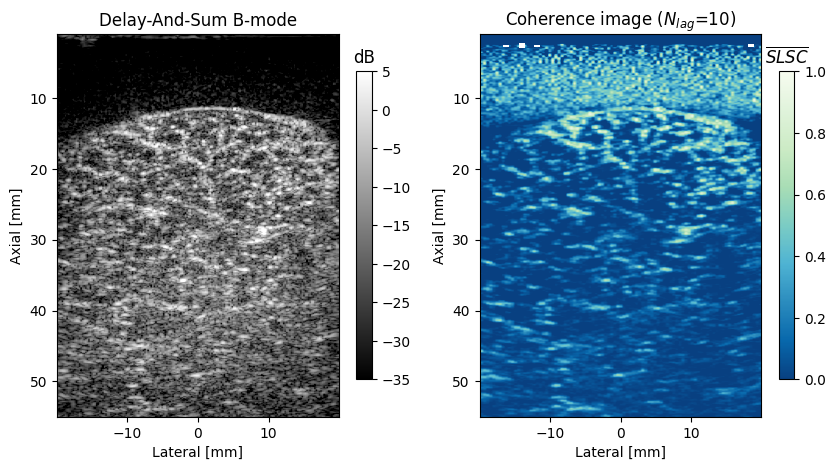

In [12]:
description = f"SOS = {sospeak:0.00f} m/s, time to make beamformer: {(t2-t1):0.02f} s,\ntime to beamform: {(t3-t2):0.02f} s, time to calc coherence: {(t5-t4):0.02f} s"

ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
ax = axes[1]
pltim = ax.imshow(locpeak.T, cmap='GnBu_r', extent=ex_axlat, vmin=-0.0, vmax=1)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title(f"Coherence image ($N_{{lag}}$={nlag})")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("$\\overline{SLSC}$")

env = np.abs(hilbert(np.sum(im_txsum, axis=0), axis=-1)).T
logged = 20 * np.log10(env/np.nanpercentile(env, 99))

ax = axes[0]
pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Delay-And-Sum B-mode")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")
# fig.suptitle(description)
plt.show()

# Make delay-multiply-and-sum B-modes

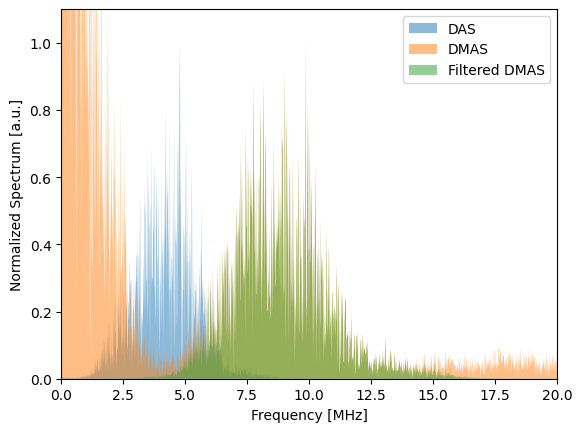

In [15]:
das = np.sum(im_txsum, axis=0)
nlag = 10
dmas = 0
for nlag in range(1, nlag+1):
    product = im_txsum[:-nlag]*im_txsum[nlag:]
    dmas += np.sum(np.sign(product)*np.sqrt(np.abs(product)), axis=0)

dz = zout[1] - zout[0]
dt = 2*dz/sospeak

dmas_vec = dmas[dmas.shape[0]//2,:]
das_vec = das[das.shape[0]//2,:]
b, a = butter(N=3, Wn=[5E6, 15E6], btype='bandpass', fs=1/dt)
dmas_vec_filt = filtfilt(b, a, dmas_vec)

FREQS    = 1E-6*np.fft.fftshift(np.fft.fftfreq(len(dmas_vec), dt))
DAS_VEC  = np.abs(np.fft.fftshift(np.fft.fft(das_vec)))
DMAS_VEC = np.abs(np.fft.fftshift(np.fft.fft(dmas_vec)))
DMAS_VEC_FILT = np.abs(np.fft.fftshift(np.fft.fft(dmas_vec_filt)))

plt.figure()
plt.fill_between(FREQS, DAS_VEC/np.max(DAS_VEC), 0, alpha=0.5, label="DAS")
plt.fill_between(FREQS, DMAS_VEC/np.max(DMAS_VEC[FREQS > 5]), 0, alpha=0.5, label="DMAS")
plt.fill_between(FREQS, DMAS_VEC_FILT/np.max(DMAS_VEC_FILT), 0, alpha=0.5, label="Filtered DMAS")
plt.xlim(0, 20)
plt.ylim(0, 1.1)
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Spectrum [a.u.]")
plt.show()

dmas_filt = filtfilt(b, a, dmas, axis=-1)

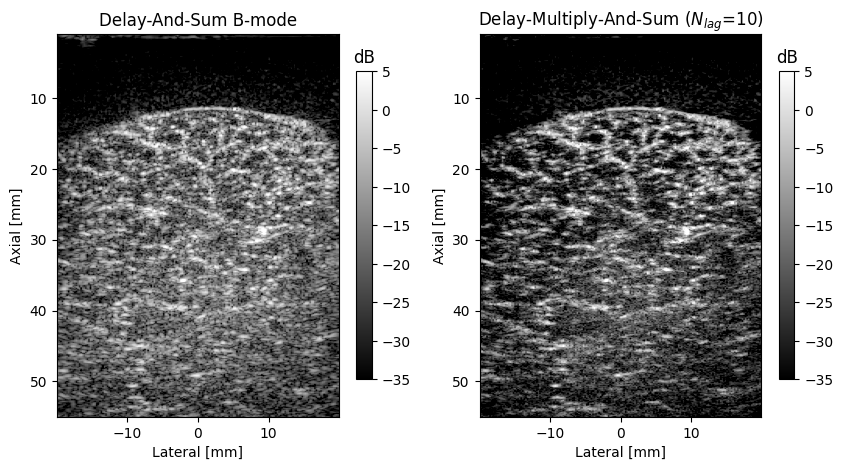

In [17]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

env = np.abs(hilbert(das, axis=-1)).T
logged = 20 * np.log10(env/np.nanpercentile(env, 99))

ax = axes[0]
pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Delay-And-Sum B-mode")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")

env = np.abs(hilbert(dmas_filt, axis=-1)).T
logged = 20 * np.log10(env/np.nanpercentile(env, 99))

ax = axes[1]
pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title(f"Delay-Multiply-And-Sum ($N_{{lag}}$={nlag})")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")

plt.show()